# Линейные градиентные методы

<img src="https://www.dropbox.com/s/ebyezjr6oxbouwl/lr_meme.gif?raw=1">

<img src="https://www.dropbox.com/s/kqoqmfxk90ab1e0/lr_meme2.png?raw=1">

Как обычно, загрузим базовые библиотеки, которые нам обязательно пригодятся:

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

## 0. Переобучение. Мотивационный пример

Напомню, что линейная регрессия &mdash; это модель следующего вида:
$$a(x) = \langle w, x \rangle + w_0$$
где $w \in \mathbb{R}^d$, $w_0 \in \mathbb{R}$. Обучить линейную регрессию &mdash; значит найти $w$ и $w_0$.

Одна из самых больших проблем машинного обучения - это переобуение. Рассмотрим его проявление на конкретном примере. Рассмотрим зависимость $y(x) = \cos(1.5\pi x)$, $y$ &mdash; целевая переменная, а $x$ - объект (просто число от 0 до 1). Возьмём 30 случайных точек $x_i$ в отрезке $[0;1]$ и смоделируем шум, зашумив значение функции нормальным шумом: $\tilde{y}_i = y(x_i) + \mathcal{N}(0, 0.01)$.

Попытаемся обучить три разных линейных модели: признаки для первой &mdash;  $\{x\}$, для второй &mdash; $\{x, x^2, x^3, x^4\}$, для третьей &mdash; $\{x, \dots, x^{20}\}$.

Собственно, сгенерируем данные:

In [2]:
np.random.seed(36)

# жалкая пародия: обучающая выборка
x_objects = np.random.uniform(0, 1, size=30)
y_objects = np.cos(1.5 * np.pi * x_objects) + np.random.normal(scale=0.1, size=x_objects.shape)

# неповторимый оригинал: реальная зависимость
x = np.linspace(0, 1, 100)
y = np.cos(1.5 * np.pi * x)

Наши новые друзья отныне и навек: [`sklearn.linear_model.LinearRegression`](https://scikit-learn.org/0.21/modules/generated/sklearn.linear_model.LinearRegression.html) и [`sklearn.preprocessing.PolynomialFeatures`](https://scikit-learn.org/0.21/modules/generated/sklearn.preprocessing.PolynomialFeatures.html)

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

Переходим к эксперименту!

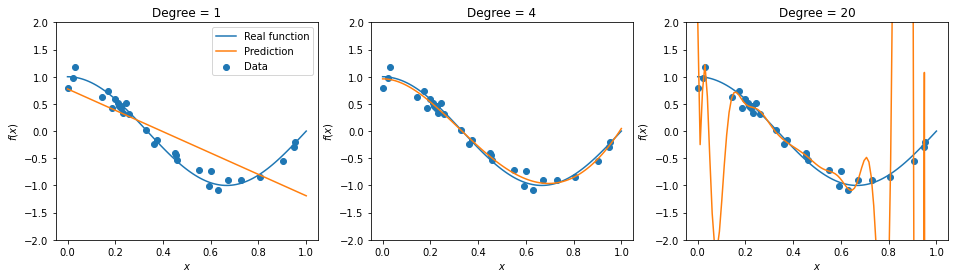

In [4]:
# у нас будет три графика
fig, axs = plt.subplots(figsize=(16, 4), ncols=3)

# перебираем степень полинома для генерации фичей, как и договаривались
for i, degree in enumerate([1, 4, 20]):
    # преобразовываем объекты
    X_objects = PolynomialFeatures(degree).fit_transform(x_objects.reshape(-1, 1))
    X = PolynomialFeatures(degree).fit_transform(x.reshape(-1, 1))
    
    # обучаем линейную регрессию
    regr = LinearRegression().fit(X_objects, y_objects)
    
    # предсказываем истинные метки для желаемых объектов
    y_pred = regr.predict(X)
    
    # рисуем что получилось
    axs[i].plot(x, y, label="Real function")
    axs[i].scatter(x_objects, y_objects, label="Data")
    axs[i].plot(x, y_pred, label="Prediction")
    if i == 0:
        axs[i].legend()
    axs[i].set_title("Degree = %d" % degree)
    axs[i].set_xlabel("$x$")
    axs[i].set_ylabel("$f(x)$")
    axs[i].set_ylim(-2, 2)
    
# ну и выводим на экран
plt.show()

Хороший вопрос: почему первая модель получилась такой плохой, а третья так сильно переобучилась?

Чтобы избежать переобучения, модель регуляризуют. Обычно переобучения в линейных моделях связаны с большими весами, а поэтому модель часто штрафуют за большие значения весов, добавляя к функционалу качества, например, квадрат $\ell^2$-нормы вектора $w$:

$$Q_{reg}(X, y, a) = Q(X, y, a) + \lambda \|w\|_2^2$$

Это слагаемое называют $\ell_2$-регуляризатором, а коэффициент $\lambda$ &mdash; коэффициентом регуляризации.

Если её использовать, то...

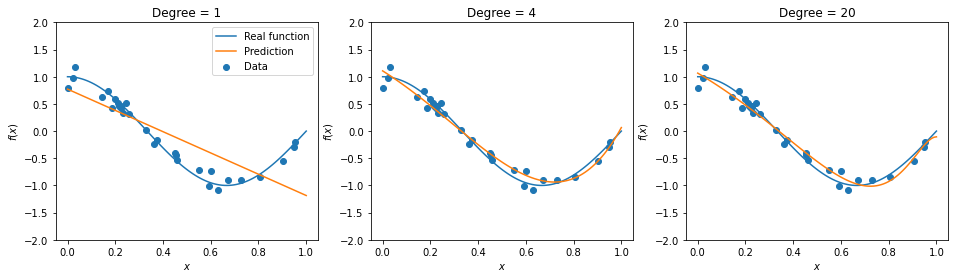

In [5]:
from sklearn.linear_model import Ridge

# у нас будет три графика
fig, axs = plt.subplots(figsize=(16, 4), ncols=3)

# перебираем степень полинома для генерации фичей, как и договаривались
for i, degree in enumerate([1, 4, 20]):
    # преобразовываем объекты
    X_objects = PolynomialFeatures(degree).fit_transform(x_objects.reshape(-1, 1))
    X = PolynomialFeatures(degree).fit_transform(x.reshape(-1, 1))
    
    # обучаем линейную регрессию
    regr = Ridge(alpha=0.01).fit(X_objects, y_objects)
    
    # предсказываем истинные метки для желаемых объектов
    y_pred = regr.predict(X)
    
    # рисуем что получилось
    axs[i].plot(x, y, label="Real function")
    axs[i].scatter(x_objects, y_objects, label="Data")
    axs[i].plot(x, y_pred, label="Prediction")
    if i == 0:
        axs[i].legend()
    axs[i].set_title("Degree = %d" % degree)
    axs[i].set_xlabel("$x$")
    axs[i].set_ylabel("$f(x)$")
    axs[i].set_ylim(-2, 2)
    
# ну и выводим на экран
plt.show()

## 1. Загрузка данных

Мы будем работать с данными из соревнования [House Prices: Advanced Regression Techniques](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview), в котором требовалось предсказать стоимость жилья. Давайте сначала загрузим и немного изучим [данные](https://yadi.sk/i/Y5sO9Cd_wG-ipw).

In [6]:
data = pd.read_csv("train.csv")
data.head()

FileNotFoundError: ignored

Стоит заметить, что у данных есть поле `Id`. Такие поля склонны вызывать переобучение, поэтому удалим его. А предсказать нам надо `SalePrice`, его и выделим в отдельную переменную:

In [ ]:
data = data.drop(columns=["Id"])

y = data["SalePrice"]
X = data.drop(columns=["SalePrice"])

Хорошие вопросы:
* Почему поля типа `Id` могут вызвать переобучение модели (не обязательно линейной)?
* Почему стоит дополнительно отделять валидационную выборку?
* Обратите внимание на фиксацию `random_state` при сплите данных. Почему это важно?

## 2. Кросс-валидация

Разделим данные в пропорции 70/30. Нет ничего проще!

In [ ]:
n = X.shape[0]
train_size = int(n * 0.7)
test_size = n - train_size
X_train = X[:train_size]
X_test = X[train_size:]
y_train = y[:train_size]
y_test = y[train_size:]

**Неправильно!!!**

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

**Правильно!**

## 3. EDA

EDA - Exploratory data analysis или, по-русски, разведочный анализ данных. Позволяет понять, с чем вы вообще работаете. На kaggle есть даже специальные азиаты, которые на всех соревнованиях делают быстрее всех красивые EDA и поднимают медальки.

Посмотрим на то, как распределены ответы, которые нам нужно предсказать:

In [ ]:
sns.distplot(y_train)

Пока что откнинем все нечисловые признаки и будем работать только с числовыми. Ну и, помимо всего прочего, как-нибудь заполним пропуски в данных:

In [ ]:
numeric_data = X_train.select_dtypes([np.number])
numeric_data_mean = numeric_data.mean()
numeric_features = numeric_data.columns

X_train = X_train.fillna(numeric_data_mean)
X_test = X_test.fillna(numeric_data_mean)

Обучить мы хотим линейную модель. Чтобы понять, насколько это целесообразно, посмотрим на корреляции Пирсона между целевой переменной и признаками:

In [ ]:
correlations = {
    feature: np.corrcoef(X_train[feature], y_train)[0][1]
    for feature in numeric_features
}
sorted_correlations = sorted(correlations.items(), key=lambda x: x[1], reverse=True)
features_order = [x[0] for x in sorted_correlations]
correlations = [x[1] for x in sorted_correlations]

plot = sns.barplot(y=features_order, x=correlations)
plot.figure.set_size_inches(15, 10)

Посмотрим на признаки из начала списка. Для этого нарисуем график зависимости целевой переменной от каждого из признаков. На этом графике каждая точка соответствует паре признак-таргет:

In [ ]:
fig, axs = plt.subplots(figsize=(16, 5), ncols=3)
for i, feature in enumerate(["GrLivArea", "GarageArea", "TotalBsmtSF"]):
    axs[i].scatter(X_train[feature], y_train, alpha=0.2)
    axs[i].set_xlabel(feature)
    axs[i].set_ylabel("SalePrice")
plt.tight_layout()

## 4. Обучение модели

Обучим линейную модель. Вроде формулы простые, можно легко написать свой класс:

In [ ]:
class MoyaLineynayaRegressia():
    def __init__(self):
        pass
    
    def obuchenie(self, X, y):
        pass
    
    def primenenie(X):
        pass

**Неправильно!!!**

In [ ]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso

model = LinearRegression()
model.fit(X_train[numeric_features], y_train)
y_pred = model.predict(X_test[numeric_features])
y_train_pred = model.predict(X_train[numeric_features])

**Правильно!**

В `sklearn` есть несколько классов, реализующих линейную регрессию:
* [`LinearRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) &mdash; "классическая" линейная регрессия с оптимизацией MSE. Веса находятся как точное решение: $w^* = (X^TX)^{-1}X^Ty$
* [`Ridge`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html) &mdash; линейная регрессия с оптимизацией MSE и $\ell_2$-регуляризацией
* [`Lasso`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) &mdash; линейная регрессия с оптимизацией MSE и $\ell_1$-регуляризацией

У моделей из `sklearn` есть методы `fit` и `predict`. Первый принимает на вход обучающую выборку и вектор целевых переменных и обучает модель, второй, будучи вызванным после обучения модели, возвращает предсказание на выборке.

## 5. Оценка качества

И в конце, посчитаем какую-нибудь метрику, например, RMSE. Благо, пользоваться numpy мы уже научились!

In [ ]:
print (np.sum((y_pred - y_test)**2)/len(y_test))

**Неправильно!!!**

In [ ]:
from sklearn.metrics import mean_squared_error

print("Test MSE = %.4f" % mean_squared_error(y_test, y_pred))
print("Train MSE = %.4f" % mean_squared_error(y_train, y_train_pred))

**Правильно!**

Можем воспользоваться не только проверкой на тестовой выборке, но и K-Fold кросс-валидацией!
<img src="https://docs.splunk.com/images/thumb/e/ee/Kfold_cv_diagram.png/1200px-Kfold_cv_diagram.png" width=50%>

In [ ]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(model, X_train[numeric_features], y_train, cv=10, scoring="neg_mean_squared_error")
print("Cross validation scores:\n\t", "\n\t".join("%.4f" % x for x in cv_scores))
print("Mean CV MSE = %.4f" % np.mean(-cv_scores))

Хороший вопрос: почему скоры отрицательные?

В качестве метрики качества в соревновании использовалось RMSE (Root Mean Squared Error), а не MSE, которое мы считали выше (и по отложенной выборке и при кросс-валидации):
$$\text{RMSE}(X, y, a) = \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} (y_i - a(x_i))^2}$$

RMSE в чистом виде не входит в стандартные метрики `sklearn`, но мы всегда можем определить свою метрику и использовать ее в некоторых функциях `sklearn`, например, `cross_val_score`. Для этого нужно воспользоваться `sklearn.metrics.make_scorer`.

In [ ]:
from sklearn.metrics import make_scorer

def rmse(y_true, y_pred):
    error = (y_true - y_pred) ** 2
    return np.sqrt(np.mean(error))

rmse_scorer = make_scorer(
    rmse,
    greater_is_better=False
)

In [ ]:
print("Test RMSE = %.4f" % rmse(y_test, y_pred))
print("Train RMSE = %.4f" % rmse(y_train, y_train_pred))

Для того, чтобы иметь некоторую точку отсчета, удобно посчитать оптимальное значение функции потерь при константном предсказании.

**Задание 1.** 
* (*0.5 балла*) Подумайте, чему равна оптимальная константа для RMSE. Посчитайте качество модели, которая выдаёт в качестве ответа константу.

In [ ]:
### YOUR CODE HERE

## 6. Изучение и улучшение модели

Давайте посмотрим на то, какие же признаки оказались самыми "сильными". Для этого визуализируем веса, соответствующие признакам. Чем больше вес &mdash; тем более сильным является признак.

Хороший вопрос: почему это не совсем правда?

In [ ]:
def show_weights(features, weights, scales):
    fig, axs = plt.subplots(figsize=(14, 10), ncols=2)
    sorted_weights = sorted(zip(weights, features, scales), reverse=True)
    weights = [x[0] for x in sorted_weights]
    features = [x[1] for x in sorted_weights]
    scales = [x[2] for x in sorted_weights]
    sns.barplot(y=features, x=weights, ax=axs[0])
    axs[0].set_xlabel("Weight")
    sns.barplot(y=features, x=scales, ax=axs[1])
    axs[1].set_xlabel("Scale")
    plt.tight_layout()

In [ ]:
show_weights(numeric_features, model.coef_, X_train[numeric_features].std())

Будем масштабировать наши признаки перед обучением модели. Это, среди, прочего, сделает нашу регуляризацию более честной: теперь все признаки будут регуляризоваться в равной степени.

In [ ]:
# найти среднее, дисперсию и преобразовать руками

**Неправильно!!!**

Для этого воспользуемся трансформером [`sklearn.preprocessing.StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html). Трансформеры в `sklearn` имеют методы `fit` и `transform`. Метод `fit` принимает на вход обучающую выборку и считает по ней необходимые значения (например статистики, как `StandardScaler`: среднее и стандартное отклонение каждого из признаков). `transform` применяет преобразование к переданной выборке.

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[numeric_features])
X_test_scaled = scaler.transform(X_test[numeric_features])

**Правильно!**

In [ ]:
model = LinearRegression()
model.fit(X_train[numeric_features], y_train)
y_pred = model.predict(X_test[numeric_features])
y_train_pred = model.predict(X_train[numeric_features])
print("Test RMSE = %.4f" % rmse(y_test, y_pred))
print("Train RMSE = %.4f" % rmse(y_train, y_train_pred))

In [ ]:
model = LinearRegression()
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)
y_train_pred = model.predict(X_train_scaled)
print("Test RMSE = %.4f" % rmse(y_test, y_pred))
print("Train RMSE = %.4f" % rmse(y_train, y_train_pred))

Хороший вопрос: значения почти не изменились. Почему?

In [ ]:
scales = pd.Series(data=X_train_scaled.std(axis=0), index=numeric_features)
show_weights(numeric_features, model.coef_, scales)

Наряду с параметрами (веса $w$, $w_0$), которые модель оптимизирует на этапе обучения, у модели есть и гиперпараметры. У нашей модели это `alpha` &mdash; коэффициент регуляризации. Подбирают его обычно по сетке, измеряя качество на валидационной (не тестовой) выборке или с помощью кросс-валидации. Посмотрим, как это можно сделать (заметьте, что мы перебираем `alpha` по логарифмической сетке, чтобы узнать оптимальный порядок величины).

In [ ]:
# перебрать по сетке и выбрать лучшее руками

**Неправильно!!!**

Для перебора по сетке можно использовать [`sklearn.model_selection.GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV)

In [ ]:
from sklearn.model_selection import GridSearchCV

alphas = np.logspace(-2, 3, 20)
searcher = GridSearchCV(Ridge(), [{"alpha": alphas}], scoring=rmse_scorer, cv=10)
searcher.fit(X_train_scaled, y_train)

best_alpha = searcher.best_params_["alpha"]
print("Best alpha = %.4f" % best_alpha)

plt.plot(alphas, -searcher.cv_results_["mean_test_score"])
plt.xscale("log")
plt.xlabel("alpha")
plt.ylabel("CV score")

**Правильно!**

Попробуем обучить модель с подобранным коэффициентом регуляризации, выстроив пайплайн для будущего обучения и применения моделей:

In [ ]:
# вызвать подряд методы для трансфорамцаии, а потом функцию подсчёта ответа

**Неправильно!!!**

Воспользуемся очень удобным классом [`sklearn.pipeline.Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html): обучение модели часто представляется как последовательность некоторых действий с обучающей и тестовой выборками (например, сначала нужно отмасштабировать выборку (причем для обучающей выборки нужно применить метод `fit`, а для тестовой &mdash; `transform`), а затем обучить/применить модель (для обучающей `fit`, а для тестовой &mdash; `predict`). `Pipeline` позволяет хранить эту последовательность шагов и корректно обрабатывает разные типы выборок: и обучающую, и тестовую.

In [ ]:
from sklearn.pipeline import Pipeline

simple_pipeline = Pipeline([
    ('scaling', StandardScaler()),
    ('regression', Ridge(best_alpha))
])

model = simple_pipeline.fit(X_train[numeric_features], y_train)
y_pred = model.predict(X_test[numeric_features])
print("Test RMSE = %.4f" % rmse(y_test, y_pred))

**Правильно!**

## 7. Ещё подходы к улучшению модели

Кроме того, чтобы улушать качество модели, можно пытаться оптимизровать ту память, которую она занимает, либо время, которое она работает (привет, алгоритмы!)

В нашем случае и за время работы, и за занимаемую память отвечают веса модели. А именно, их количество. Но как бы их уменьшить с минимальным изменением качества самой модели?

**Задание 2.** 
* (*1 балл*) Занулите все веса в нашей модели. Далее, добавляйте веса по-одному, начиная с самых больших по модулю и заканчивая самыми маленькими. На каждой итерации посчитайте значение RMSE. Постройте график зависимости значения RMSE от количества ненулевых весов. 
* (*1 балл*) Зануление - это хорошо, но лучше не веса занулять, а признаки выбрасывать. Проделайте аналогичную той, что написана выше, процедуре, но разнуляйте не веса, а признаки, которые имели в изначальной модели самый большой вес и на каждом шаге переобучайте модель. Сильно ли отличается качество?

In [ ]:
### YOUR CODE HERE ###

Для улучшения качества модели в том числе используют и feature engineering, а именно, ручное составление новых фичей. Либо производят некотрое преобразование целевой переменной, чтобы в текущем пространстве её было проще приблизить.

Так как в нашей задаче достаточно большие значения ответов, возможно, предугадывать их логарифмы будет проще.

**Задание 3.** 
* (*0.5 балла*) Постройте модель, которая предсказывает логарифм цены, а не саму цену. Посчитайте RMSE на предсказании цены такой моделью (цены, не логарифма!)

In [ ]:
### YOUR CODE HERE ###